# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# TODO: Make all necessary imports.
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


2024-12-27 17:04:25.046246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-27 17:04:25.046313: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-27 17:04:25.046394: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [2]:
# Load the Dataset
# TODO: Load the Oxford Flowers 102 dataset using TensorFlow Datasets.
# The `as_supervised=True` argument returns the data as tuples (image, label).
dataset, info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

# TODO: Create a training set, a validation set and a test set.
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/2 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/3 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/3 [00:02<?, ? url/s]
Dl Size...: 0 MiB [00:02, ? MiB/s]

Dl Completed...:  33%|███▎      | 1/3 [00:02<00:04,  2.11s/ url]
Dl Size...: 0 MiB [00:02, ? MiB/s]

Dl Size...:   0%|          | 0/328 [00:02<?, ? MiB/s]

Dl Size...:   0%|          | 0/328 [00:02<?, ? MiB/s]

Dl Size...:   0%|          | 0/328 [00:02<?, ? MiB/s]

Extraction completed...: 0 file [00:02, ? file/s]
Dl Size...:   0%|          | 1/328 [00:02<14:47,  2.72s/ MiB]

Dl Size...:   1%|          | 2/328 [00:02<14:45,  2.72s/ MiB]

Dl Size...:   1%|          | 3/328 [00:02<14:42,  2.72s/ MiB]

Dl Size...:   1%|          | 4/328 [00:02<14:39

Dl Size...:  16%|█▋        | 54/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  17%|█▋        | 55/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  17%|█▋        | 56/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  17%|█▋        | 57/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  18%|█▊        | 58/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  18%|█▊        | 59/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  18%|█▊        | 60/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  19%|█▊        | 61/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  19%|█▉        | 62/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  19%|█▉        | 63/328 [00:05<00:20, 13.20 MiB/s]

Dl Size...:  20%|█▉        | 64/328 [00:05<00:19, 13.20 MiB/s]

Dl Size...:  20%|█▉        | 65/328 [00:05<00:19, 13.20 MiB/s]

Dl Size...:  20%|██        | 66/328 [00:05<00:19, 13.20 MiB/s]

Dl Size...:  20%|██        | 67/328 [00:05<00:19, 13.20 MiB/s]

Dl Size...:  21%|██        | 68/328 [00:05<00:19, 13.20 MiB/s]

Dl Size...:  21%|██        | 69/328 [00:

Dl Size...:  35%|███▌      | 115/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  35%|███▌      | 116/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  36%|███▌      | 117/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  36%|███▌      | 118/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  36%|███▋      | 119/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  37%|███▋      | 120/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  37%|███▋      | 121/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  37%|███▋      | 122/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  38%|███▊      | 123/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  38%|███▊      | 124/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  38%|███▊      | 125/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  38%|███▊      | 126/328 [00:07<00:10, 19.59 MiB/s]

Dl Size...:  39%|███▊      | 127/328 [00:07<00:10, 19.59 MiB/s]

Extraction completed...: 0 file [00:07, ? file/s]
Dl Size...:  39%|███▉      | 128/328 [00:07<00:09, 21.52 MiB/s]

Dl Size...:  39%|███▉      | 129/328 [00

Dl Size...:  54%|█████▎    | 176/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  54%|█████▍    | 177/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  54%|█████▍    | 178/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  55%|█████▍    | 179/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  55%|█████▍    | 180/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  55%|█████▌    | 181/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  55%|█████▌    | 182/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  56%|█████▌    | 183/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  56%|█████▌    | 184/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  56%|█████▋    | 185/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  57%|█████▋    | 186/328 [00:09<00:06, 23.56 MiB/s]

Dl Size...:  57%|█████▋    | 187/328 [00:10<00:05, 23.56 MiB/s]

Dl Size...:  57%|█████▋    | 188/328 [00:10<00:05, 23.56 MiB/s]

Extraction completed...: 0 file [00:10, ? file/s]
Dl Size...:  58%|█████▊    | 189/328 [00:10<00:05, 25.73 MiB/s]

Dl Size...:  58%|█████▊    | 190/328 [00

Dl Size...:  72%|███████▏  | 236/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  72%|███████▏  | 237/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  73%|███████▎  | 238/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  73%|███████▎  | 239/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  73%|███████▎  | 240/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  73%|███████▎  | 241/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  74%|███████▍  | 242/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  74%|███████▍  | 243/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  74%|███████▍  | 244/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  75%|███████▍  | 245/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  75%|███████▌  | 246/328 [00:11<00:03, 26.35 MiB/s]

Dl Size...:  75%|███████▌  | 247/328 [00:12<00:03, 26.35 MiB/s]

Dl Size...:  76%|███████▌  | 248/328 [00:12<00:03, 26.35 MiB/s]

Extraction completed...: 0 file [00:12, ? file/s]
Dl Size...:  76%|███████▌  | 249/328 [00:12<00:02, 27.68 MiB/s]

Dl Size...:  76%|███████▌  | 250/328 [00

Dl Size...:  91%|█████████ | 297/328 [00:13<00:01, 28.06 MiB/s]

Dl Size...:  91%|█████████ | 298/328 [00:13<00:01, 28.06 MiB/s]

Dl Size...:  91%|█████████ | 299/328 [00:13<00:01, 28.06 MiB/s]

Dl Size...:  91%|█████████▏| 300/328 [00:13<00:00, 28.06 MiB/s]

Dl Size...:  92%|█████████▏| 301/328 [00:13<00:00, 28.06 MiB/s]

Dl Size...:  92%|█████████▏| 302/328 [00:13<00:00, 28.06 MiB/s]

Dl Size...:  92%|█████████▏| 303/328 [00:13<00:00, 28.06 MiB/s]

Dl Size...:  93%|█████████▎| 304/328 [00:13<00:00, 28.06 MiB/s]

Dl Size...:  93%|█████████▎| 305/328 [00:14<00:00, 28.06 MiB/s]

Dl Size...:  93%|█████████▎| 306/328 [00:14<00:00, 28.06 MiB/s]

Dl Size...:  94%|█████████▎| 307/328 [00:14<00:00, 28.06 MiB/s]

Dl Size...:  94%|█████████▍| 308/328 [00:14<00:00, 28.06 MiB/s]

Dl Size...:  94%|█████████▍| 309/328 [00:14<00:00, 28.06 MiB/s]

Extraction completed...: 0 file [00:14, ? file/s]
Dl Size...:  95%|█████████▍| 310/328 [00:14<00:00, 28.80 MiB/s]

Dl Size...:  95%|█████████▍| 311/328 [00

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Extraction completed...:   7%|▋         | 542/8189 [01:41<15:12,  8.38 file/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Extraction completed...:  44%|████▍     | 3635/8189 [02:05<00:34, 131.06 file/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Extraction completed...:  51%|█████     | 4178/8189 [02:09<00:29, 134.54 file/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Extraction completed...:  56%|█████▌    | 4598/8189 [02:12<00:26, 136.43 file/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 28.80 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:16<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Extraction completed...:  71%|███████   | 5816/8189 [02:21<00:17, 135.20 file/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████



Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Extraction completed...

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Extraction completed...:  84%|████████▍ | 6889/8189 [02:29<00:09, 131.83 file/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 28.80 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Extraction completed...:  87%|████████▋ | 7157/8189 [02:31<00:07, 132.82 file/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 28.80 MiB/s]

Dl Completed...: 100%|██████████| 3/3 [02:31<00:00,  5.25s/ url], 132.84 file/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 28.80 MiB/s]

Dl Size..

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Extraction completed...:  91%|█████████ | 7441/8189 [02:33<00:05, 136.97 file/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:39<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Extraction completed...: 100%|█████████▉| 8183/8189 [02:40<00:00, 107.15 file/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:40<00:00, 28.80 MiB/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]
                                                                             
Shuffling /home/student/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete7S9LI4/oxford_flowers102-train.tfrecord*...:   0%|          | 0/1020 [00:00<?, ? examples/s]
Generating test examples...:  92%|█████████▏| 5646/6149 [00:03<00:00, 1867.43 examples/s]
                                              

Dataset oxford_flowers102 downloaded and prepared to /home/student/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Explore the Dataset

In [3]:
# Explore the Dataset

# TODO: Get the number of examples in each set from the dataset info.
num_train_examples = info.splits['train'].num_examples
num_validation_examples = info.splits['validation'].num_examples
num_test_examples = info.splits['test'].num_examples
print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_validation_examples}")
print(f"Number of test examples: {num_test_examples}")

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149
Number of classes: 102


In [4]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for i, (image, label) in enumerate(train_dataset.take(3)):
    print(f"Image {i+1} shape: {image.shape}")
    print(f"Label: {label.numpy()}")

Image 1 shape: (500, 667, 3)
Label: 72
Image 2 shape: (500, 666, 3)
Label: 84
Image 3 shape: (670, 500, 3)
Label: 70


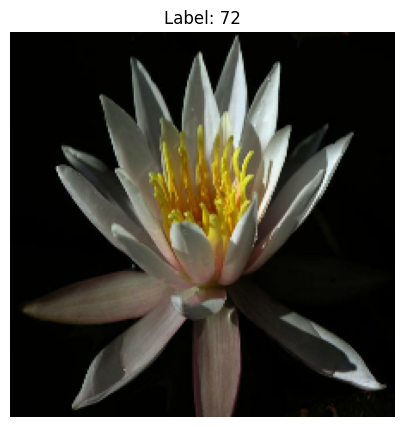

In [8]:
# Define the image size constant
IMG_SIZE = 224  # Resize images to 224x224 pixels

# Redefine preprocess_image function
def preprocess_image(image, label):
    """Resize and normalize images."""
    # Resize the image to 224x224 pixels
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Normalize the image to the range [0, 1]
    image = image / 255.0
    return image, label

# Plot 1 image from the raw training dataset
raw_train_dataset = dataset['train']  # Use the raw training dataset directly

for image, label in raw_train_dataset.take(1):  # Take one raw image-label pair
    # Apply preprocessing
    image, label = preprocess_image(image, label)
    
    # Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image.numpy())  # Convert Tensor to NumPy array for display
    plt.title(f"Label: {label.numpy()}")  # Display the corresponding label
    plt.axis('off')
    plt.show()




### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [ ]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

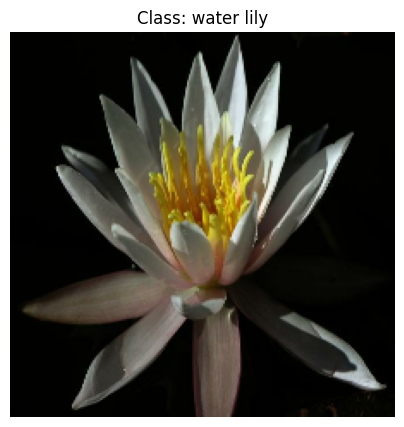

In [9]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

import json

# Load the label map
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

# Plot 1 image from the raw training dataset with the class name as the title
raw_train_dataset = dataset['train']  # Use the raw training dataset directly

for image, label in raw_train_dataset.take(1):  # Take one raw image-label pair
    # Apply preprocessing
    image, label = preprocess_image(image, label)

    # Get the class name from the label map
    class_name = class_names[str(label.numpy())]

    # Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image.numpy())  # Convert Tensor to NumPy array for display
    plt.title(f"Class: {class_name}")  # Display the corresponding class name
    plt.axis('off')
    plt.show()


## Create Pipeline

In [11]:
# TODO: Create a pipeline for each set.
# Constants
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# Preprocessing function
def preprocess_pipeline(image, label):
    """Resize, normalize, and prepare images."""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Create a pipeline for each set
train_pipeline = (
    dataset['train']
    .map(preprocess_pipeline)  # Apply preprocessing
    .shuffle(BUFFER_SIZE)      # Shuffle for randomness
    .batch(BATCH_SIZE)         # Batch the dataset
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Optimize loading
)

validation_pipeline = (
    dataset['validation']
    .map(preprocess_pipeline)  # Apply preprocessing
    .batch(BATCH_SIZE)         # Batch the dataset
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Optimize loading
)

test_pipeline = (
    dataset['test']
    .map(preprocess_pipeline)  # Apply preprocessing
    .batch(BATCH_SIZE)         # Batch the dataset
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Optimize loading
)

# Verify the pipelines
for image_batch, label_batch in train_pipeline.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")



Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

Epoch 1/10
32/32 [==============================] - 18s 218ms/step - loss: 4.3006 - accuracy: 0.1186 - val_loss: 3.0664 - val_accuracy: 0.4529
Epoch 2/10
32/32 [==============================] - 9s 174ms/step - loss: 2.0472 - accuracy: 0.5863 - val_loss: 1.7064 - val_accuracy: 0.6147
Epoch 3/10
32/32 [==============================] - 9s 167ms/step - loss: 1.0091 - accuracy: 0.7814 - val_loss: 1.2828 - val_accuracy: 0.6824
Epoch 4/10
32/32 [==============================] - 9s 165ms/step - loss: 0.5550 - accuracy: 0.8765 - val_loss: 1.0531 - val_accuracy: 0.7314
Epoch 5/10
32/32 [==============================] - 9s 167ms/step - loss: 0.3347 - accuracy: 0.9353 - val_loss: 0.9538 - val_accuracy: 0.7559
Epoch 6/10
32/32 [==============================] - 9s 167ms/step - loss: 0.2167 - accuracy: 0.9637 - val_loss: 0.8891 - val_accuracy: 0.7667
Epoch 7/10
32/32 [==============================] - 9s 168ms/step - loss: 0.1589 - accuracy: 0.9775 - val_loss: 0.8054 - val_accuracy: 0.7922
Epoch

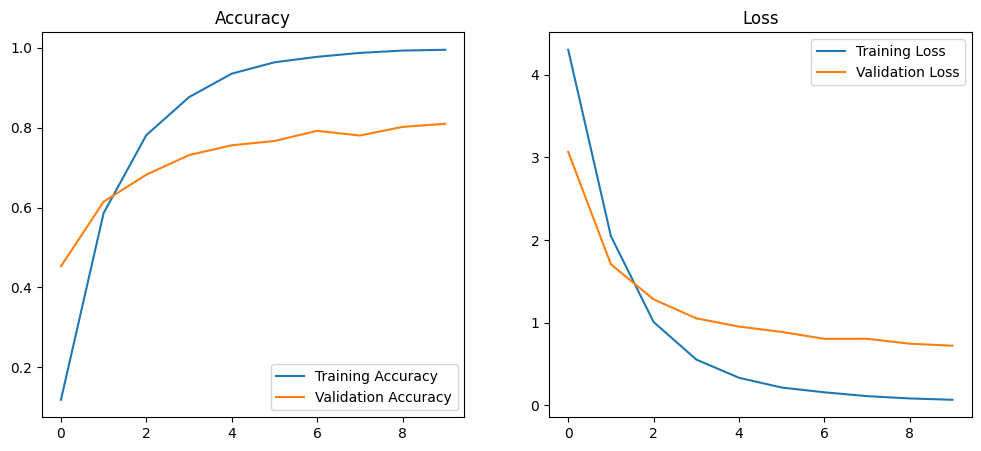

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'flower_classifier_model.h5'


In [12]:
# TODO: Build and train your network.
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the MobileNet pre-trained model
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_url, input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable=False
)

# Build the model
model = models.Sequential([
    feature_extractor_layer,  # Use MobileNet as the base
    layers.Dense(512, activation='relu'),  # Hidden layer
    layers.Dropout(0.3),  # Add dropout for regularization
    layers.Dense(num_classes, activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_pipeline,
    validation_data=validation_pipeline,
    epochs=10,  # Adjust epochs as needed
    verbose=1
)

# Plot the loss and accuracy values
def plot_training_history(history):
    """Plot the loss and accuracy during training."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training_history(history)

# Save the trained model
model.save("flower_classifier_model.h5")
print("Model saved as 'flower_classifier_model.h5'")



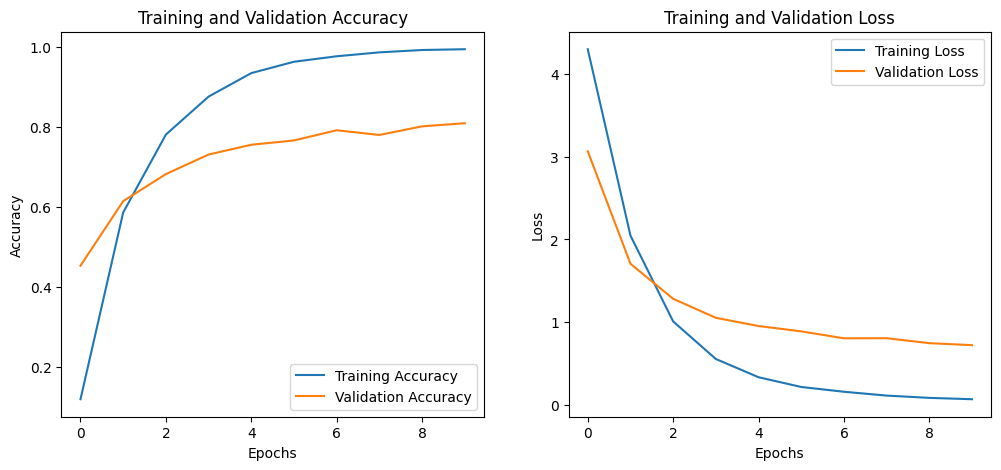

In [13]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
# Function to plot loss and accuracy during training
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy
    during the training process.
    """
    # Extract accuracy and loss values for training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create subplots for accuracy and loss
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Display the plots
    plt.show()

# Call the function with the training history
plot_training_history(history)


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_pipeline, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



193/193 [==============================] - 24s 120ms/step - loss: 0.8844 - accuracy: 0.7759
Test Loss: 0.8844
Test Accuracy: 0.7759


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [17]:
import tensorflow_hub as hub

# Save the trained model as an HDF5 file, including the KerasLayer
model.save("flower_classifier_model.h5", include_optimizer=False)
print("Model saved as 'flower_classifier_model.h5'")



Model saved as 'flower_classifier_model.h5'


## Load the Keras Model

Load the Keras model you saved above.

In [18]:
from tensorflow.keras.models import load_model
import tensorflow_hub as hub

# Load the model with KerasLayer specified as a custom object
loaded_model = load_model("flower_classifier_model.h5", custom_objects={'KerasLayer': hub.KerasLayer})

print("Model loaded successfully!")


Model loaded successfully!


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [20]:
# TODO: Create the process_image function
import tensorflow as tf
import numpy as np
from PIL import Image

# Process Image Function
def process_image(image):
    """
    Preprocess an image for model prediction.
    Converts the image to a tensor, resizes it to 224x224, 
    normalizes pixel values to the range [0, 1], 
    and returns a NumPy array.
    """
    # Convert the image to a TensorFlow Tensor
    image = tf.convert_to_tensor(image)
    
    # Resize the image to 224x224
    image = tf.image.resize(image, (224, 224))
    
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    
    # Return as a NumPy array
    return image.numpy()

def predict(image_path, model, top_k=5):
    """
    Predict the top K most likely classes for an image using a trained model.
    
    Args:
    image_path (str): Path to the input image.
    model (tf.keras.Model): Trained model.
    top_k (int): Number of top predictions to return.
    
    Returns:
    probs (list): List of top K probabilities.
    classes (list): List of top K class labels as strings.
    """
    # Load and preprocess the image
    image = Image.open(image_path)
    image = np.asarray(image)
    processed_image = process_image(image)
    
    # Add batch dimension
    processed_image = np.expand_dims(processed_image, axis=0)
    
    # Make prediction
    predictions = model.predict(processed_image)
    
    # Extract top K probabilities and class indices
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    probs = predictions[0][top_k_indices]
    classes = [str(index) for index in top_k_indices]
    
    return probs, classes

# Example usage
image_path = "path_to_your_image.jpg"
top_k = 5
probs, classes = predict(image_path, loaded_model, top_k)

print("Top probabilities:", probs)
print("Top classes:", classes)



To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

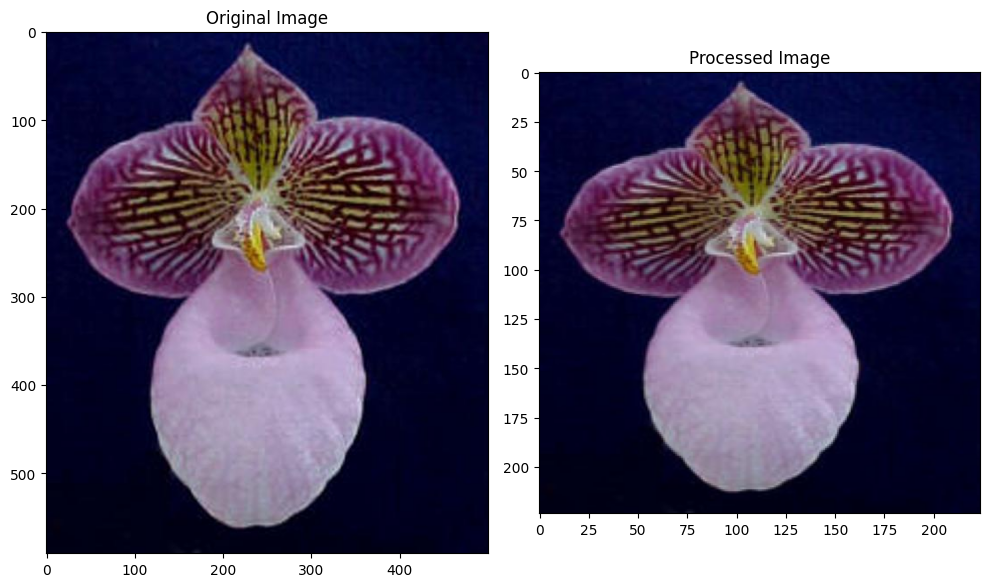

In [21]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [ ]:
# TODO: Create the predict function
def process_image(image):
    """
    Preprocess the image for the model:
    - Resize the image to 224x224.
    - Normalize pixel values to the range [0, 1].
    - Return the processed image as a NumPy array.
    """
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalize to [0, 1]
    return image.numpy()

def predict(image_path, model, top_k=5):
    """
    Predict the top K classes and their probabilities for a given image.
    
    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): The trained model.
        top_k (int): Number of top predictions to return.

    Returns:
        probs (list): Probabilities of the top K classes.
        classes (list): Class labels corresponding to the top K probabilities.
    """
    # Load the image
    image = Image.open(image_path)
    
    # Convert the image to a NumPy array
    image = np.asarray(image)
    
    # Preprocess the image
    processed_image = process_image(image)
    
    # Add the batch dimension for prediction
    processed_image = np.expand_dims(processed_image, axis=0)
    
    # Make predictions
    predictions = model.predict(processed_image)
    
    # Get the top K predictions
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]  # Indices of top K predictions
    probs = predictions[0][top_k_indices]  # Probabilities of top K predictions
    classes = [str(index) for index in top_k_indices]  # Convert indices to class labels
    
    return probs, classes
# Example: Use the function to predict the top 5 classes for a sample image
image_path = "path_to_your_image.jpg"
top_k = 5
probs, classes = predict(image_path, loaded_model, top_k)

print("Top probabilities:", probs)
print("Top classes:", classes)


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [22]:
# TODO: Plot the input image along with the top 5 classes
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(image_path, model, class_names, top_k=5):
    """
    Plot the input image and a bar chart of the top K predicted class probabilities.

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained model for prediction.
        class_names (dict): Dictionary mapping class indices to flower names.
        top_k (int): Number of top predictions to display.
    """
    # Make predictions using the predict function
    probs, classes = predict(image_path, model, top_k)
    
    # Convert classes to flower names
    flower_names = [class_names[c] for c in classes]
    
    # Load and preprocess the image
    image = Image.open(image_path)
    image = process_image(np.asarray(image))
    
    # Plot the input image
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    
    # Plot the probabilities as a bar chart
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(flower_names))
    plt.barh(y_pos, probs[::-1])  # Reverse order for a top-down plot
    plt.yticks(y_pos, flower_names[::-1])  # Reverse order for names
    plt.xlabel("Probability")
    plt.title("Top Predictions")
    
    plt.tight_layout()
    plt.show()

